# 报告主题：
对某知名电商的销售数据做深度分析，运用rfm模型，并制作仪表盘。

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

In [2]:
df_path = 'C:/Users/xutian/Downloads/电子产品销售分析.csv'
df_u = pd.read_csv(df_path,encoding='gbk')

## 1. 数据处理

In [3]:
df_u.describe()

,order_id,product_id,category_id,price,user_id,age
count,5.641690e+05,5.641690e+05,5.641690e+05,564169.000000,5.641690e+05,564169.000000
mean,2.370552e+18,1.695711e+18,2.272919e+18,208.269324,1.515916e+18,33.184388
std,2.025138e+16,3.290688e+17,2.158282e+16,304.559875,2.379042e+07,10.122088
min,2.294360e+18,1.515966e+18,2.268105e+18,0.000000,1.515916e+18,16.000000
25%,2.353294e+18,1.515966e+18,2.268105e+18,23.130000,1.515916e+18,24.000000
50%,2.376886e+18,1.515966e+18,2.268105e+18,87.940000,1.515916e+18,33.000000
75%,2.388441e+18,1.515966e+18,2.268105e+18,277.750000,1.515916e+18,42.000000
max,2.388441e+18,2.388434e+18,2.374499e+18,18328.680000,1.515916e+18,50.000000


In [4]:
df_u.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
0,2020-04-24 11:50:39 UTC,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,samsung,162.01,1515915625441990000,24,女,海南
1,2020-04-24 11:50:39 UTC,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,samsung,162.01,1515915625441990000,24,女,海南
2,2020-04-24 14:37:43 UTC,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,huawei,77.52,1515915625447870000,38,女,北京
3,2020-04-24 14:37:43 UTC,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,huawei,77.52,1515915625447870000,38,女,北京
4,2020-04-24 19:16:21 UTC,2294584263154070000,2273948316817420000,2268105471367840000,NaN,karcher,217.57,1515915625443140000,32,女,广东


In [5]:
df_u.fillna('no_brand',inplace = True)
df_u = df_u.drop_duplicates('order_id')
df_u['event_time'] = pd.to_datetime(df_u['event_time']).dt.to_period('D')
df_u = df_u.set_index('event_time',drop = False)
df_u['month'] = df_u['event_time'].dt.month

In [6]:
df = df_u
user_record=df.groupby('user_id')['order_id'].count().sort_values(ascending=False)

In [7]:
user_record.describe()

count    6665.000000
mean       35.143586
std       170.449702
min         1.000000
25%        11.000000
50%        22.000000
75%        37.000000
max      7014.000000
Name: order_id, dtype: float64

In [8]:
np.percentile(user_record,90)

56.0

In [9]:
user_record

user_id
1515915625484620000    7014
1515915625484630000    5181
1515915625484640000    5061
1515915625484670000    4236
1515915625484650000    4130
                       ... 
1515915625500660000       1
1515915625500640000       1
1515915625500550000       1
1515915625500510000       1
1515915625514840000       1
Name: order_id, Length: 6665, dtype: int64

In [136]:
df = df_u
df_b = df.loc[df['user_id'].isin(user_record[user_record<56].index)]
df_b['user_level']= 'B'
df_a=df.loc[~df['user_id'].isin(list(df_b['user_id']))]
df_a['user_level']='A'
df_ab = pd.concat([df_a,df_b])

我们发现用户的订单数量差异较大，最高订单数量为7014，平均数量仅为35。
鉴于90%的用户订单数量小于56，我们将其作为分割点，并以此对客户分组。A类客户订单数量大于56，而B类客户订单数量小于56.

In [15]:
sum(df_a['price'])/sum(df_b['price'])

0.6336541258792153

In [16]:
sum(df.loc[df['user_id']==1515915625484620000]['price'])/sum(df['price'])

0.015375076001147077

经计算发现，尽管B类客户数量显著高于A类客户，但A类客户的总体消费额约为B类客户的63%，对企业整体销售数据起到了关键支撑作用。其中销售额最高的用户占了整体销售额的1.5%。
鉴于A类客户整体用户量较少，我们将重点放在B类客户上面。但A类客户在销售额上为主要客户群体，日后可做深入分析。

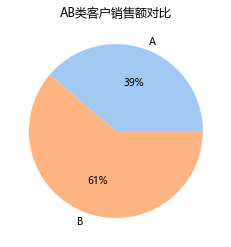

In [17]:
x=df_ab.groupby('user_level')['price'].sum()
colors = sb.color_palette('pastel')[0:5]
plt.pie(x, labels = x.index, colors = colors, autopct='%.0f%%')
plt.title('AB类客户销售额对比')
plt.show()

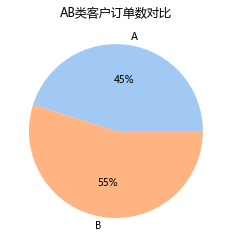

In [14]:
x=df_ab.groupby('user_level')['event_time'].count()
plt.pie(x, labels = x.index, colors = colors, autopct='%.0f%%')
plt.title('AB类客户订单数对比')
plt.show()

## 2. 消费人群/画像分析

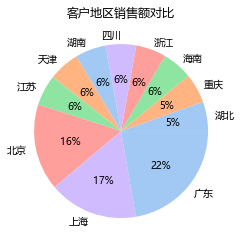

In [50]:
locc = df.groupby('local')['price'].sum().sort_values()
plt.pie(locc, labels = locc.index,colors = colors,autopct='%.0f%%')
plt.title('客户地区销售额对比')
plt.show()

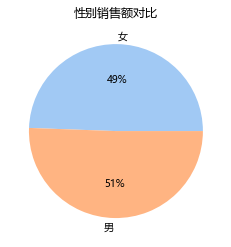

In [51]:
gender =  df.groupby('sex')['price'].sum().sort_values()
plt.pie(gender, labels = gender.index, colors=colors, autopct='%.0f%%')
plt.title('性别销售额对比')
plt.show()

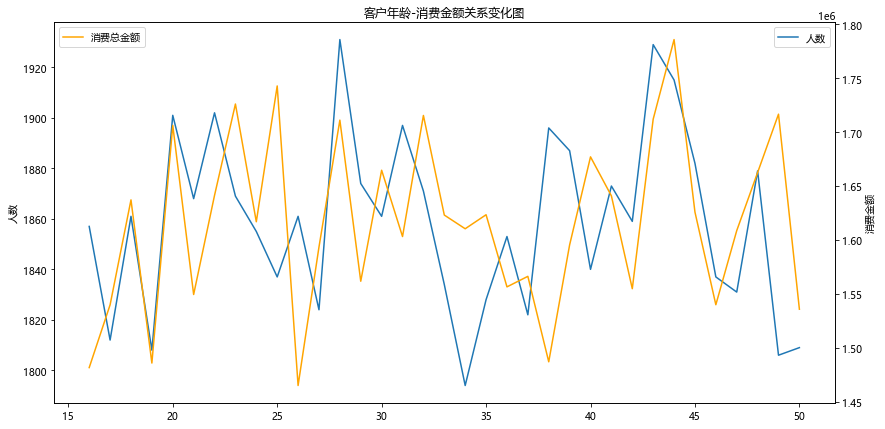

In [82]:
ax1 = df.groupby('age')['user_id'].nunique().rename('人数').plot(title='客户年龄-消费金额关系变化图',ylabel='人数',xlabel='',legend=1)
df.groupby('age')['price'].sum().rename('消费总金额').plot(ax=ax1.twinx(),color='orange',figsize=(14,7),ylabel='消费金额',legend=True,xlabel='').legend(loc=2)

我们注意到北上广占据了销售额的一半以上，可针对一线城市提高营销努力。
同时发现，客户年龄与性别并没有和销售额有太多的关联性。

## 3. 品牌销售数据

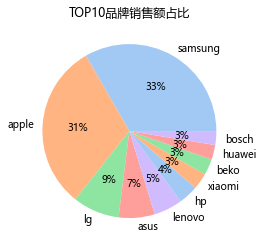

In [260]:
brand =  df.groupby('brand')['price'].sum().sort_values(ascending=False).head(10)
plt.pie(brand, labels = brand.index, colors=colors, autopct='%.0f%%')
plt.title('TOP10品牌销售额占比')
plt.show()

In [261]:
brand

brand
samsung    14062366.69
apple      13095763.25
lg          3656356.76
asus        2828600.43
lenovo      2241106.90
hp          1544365.96
xiaomi      1286315.31
beko        1258039.12
huawei      1142222.82
bosch       1086321.46
Name: price, dtype: float64

In [18]:
#Top10品牌销量占整体销量对比
brand.sum()/df['price'].sum()

0.7460814290214783

In [33]:
dfa=df_ab.groupby(['brand','user_level'],as_index=False)['price'].sum().sort_values(by=['price'],ascending=False).head(10)

In [34]:
dfa

,brand,user_level,price
58,apple,B,8694931.32
975,samsung,B,8557835.25
974,samsung,A,5504531.44
57,apple,A,4400831.93
666,lg,B,2169369.73
87,asus,B,1807026.15
665,lg,A,1486987.03
661,lenovo,B,1436280.64
86,asus,A,1021574.28
509,hp,B,934320.04


Text(0.5, 1.0, 'Top10品牌销售图')

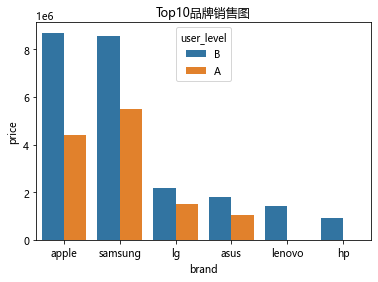

In [37]:
sb.barplot(x= 'brand',
           y='price',
           hue="user_level",
           data=dfa).set_title('Top10品牌销售图')

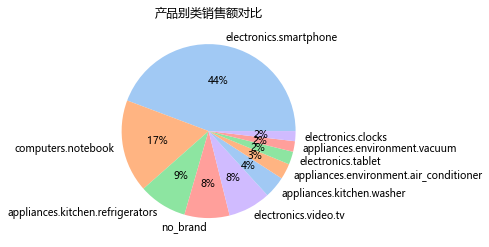

In [72]:
cate=df.groupby('category_code')['price'].sum().sort_values(ascending=False).head(10)
plt.pie(cate, labels = cate.index,colors=colors, autopct='%.0f%%')
plt.title('产品别类销售额对比')
plt.show()

尽管产品种类丰富，手机与电脑等电子产品依旧占据了大部分的销售额，相关的品牌也占据了品牌销量头部位置。鉴于此电商有多样化的需求，其他品种仍需努力加大投入。

## 4.销量分析

In [80]:
fmri = (df_ab.groupby([df_ab['event_time'].dt.month])['price'].sum()).to_frame()
fmri['month']=fmri.index

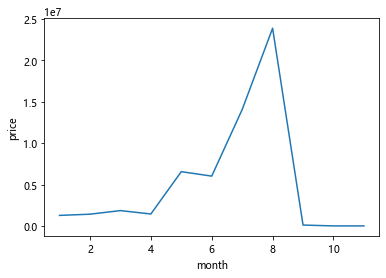

In [52]:
sb.lineplot( x = "month",
             y = "price",
             data = fmri);

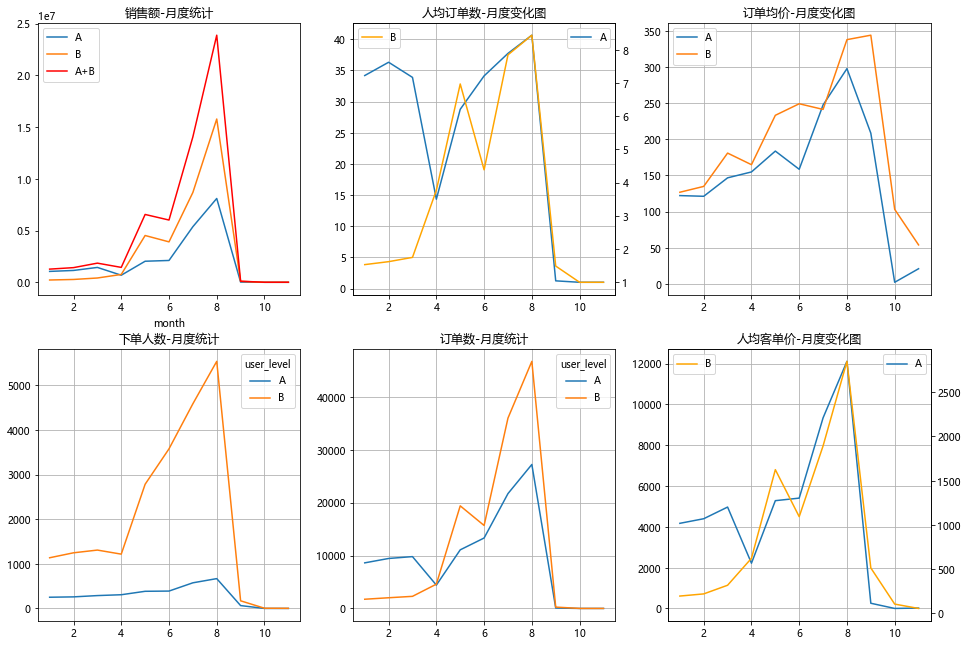

In [43]:
fig,axs = plt.subplots(2,3,figsize= (16,11))
df_ab.groupby(['month','user_level'])['price'].sum().unstack().plot(grid=True,title='销售额-月度统计',ax=axs[0,0])
df_ab.groupby('month')['price'].sum().rename('A+B').plot(ax=axs[0,0],color='r').legend(loc=2)
df_ab.groupby(['month','user_level'])['order_id'].count().unstack().plot(grid=True,title='订单数-月度统计',xlabel='',ax=axs[1,1])
(df_a.groupby('month')['price'].sum()/df_a.groupby('month')['order_id'].count()).rename('A').plot(xlabel='',ax=axs[0,2])
(df_b.groupby('month')['price'].sum()/df_b.groupby('month')['order_id'].count()).rename('B').plot(grid=True,title='订单均价-月度变化图',xlabel='',ax=axs[0,2]).legend(loc=2)
df_ab.groupby(['month','user_level']).user_id.nunique().unstack().plot(grid=True,title='下单人数-月度统计',xlabel='',ax=axs[1,0])
ax2 = (df_a.groupby('month')['order_id'].count()/df_a.groupby('month').user_id.nunique()).rename('A').plot(grid=True,xlabel='',ax=axs[0,1],legend=1)
(df_b.groupby('month')['order_id'].count()/df_b.groupby('month').user_id.nunique()).rename('B').plot(title='人均订单数-月度变化图',xlabel='',ax=ax2.twinx(),color='orange').legend(loc=2)
ax1 = (df_a.groupby('month')['price'].sum()/df_a.groupby('month').user_id.nunique()).rename('A').plot(grid=True,xlabel='',ax=axs[1,2],legend=1)
(df_b.groupby('month')['price'].sum()/df_b.groupby('month').user_id.nunique()).rename('B').plot(title='人均客单价-月度变化图',xlabel='',ax=ax1.twinx(),color='orange').legend(loc=2)


销售额高峰出现在了8月。经过拆解分析发现，8月出现了量价齐生的现象，整体都保持了正增长的趋势。
值得注意的是相较于A类用户，B类用户在8月的下单人数出现了异常增长.
鉴于8月以后的数据有限，不对其做后续分析。

### 4.1 会员分析

In [9]:
def active_status(x):
    status = []
    for i in range(11):
        if x[i]==0:
            if i ==0:
                status.append('unreg')
            else:
                status.append('unreg') if status[i-1]=='unreg' else status.append('unactive')
        else:
            if i==0:
                status.append('reg')
            else:
                if status[i-1]=='unreg':
                    status.append('reg')
                else:
                    status.append('ret') if status[i-1]=='unactive' else status.append('old')
    return pd.Series(status,index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
        

In [10]:
order_record = df.pivot_table(index = 'user_id',columns='month',values ='price',aggfunc='sum').fillna(0)
order_record.columns = df['month'].sort_values().astype('str').unique()
user_active_status = order_record.apply(active_status,axis = 1)

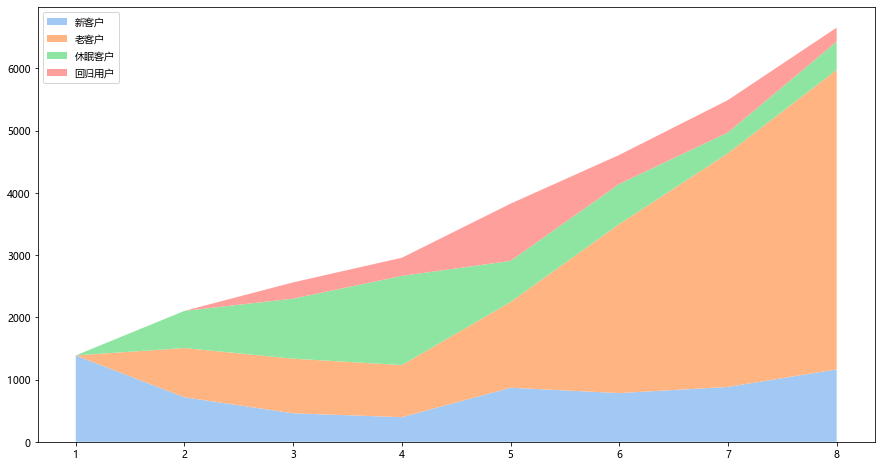

In [18]:
ax1= user_active_status.apply(lambda x: pd.value_counts(x)).drop('unreg').fillna(0).T
ax1['month']=ax1.index
ax1 = ax1.drop(['9','10','11'])
plt.figure(figsize = (15,8))
plt.stackplot(ax1.month,ax1.reg,ax1.old,ax1.unactive,ax1.ret,colors=colors, labels = ['新客户','老客户','休眠客户','回归用户'])
plt.legend(loc='upper left')
plt.show()

数据显示，8月份销售量增高的原因可归功于老用户的积累。
从5月份开始，老客户出现了大批量的回归。可针对这段时间对已注册用户展开的运营策略做复盘，总结经验。
新用户的注册数量一直保持较低的水平。可从roi的角度出发，对新用户展开定向的营销活动。

### 4.2 复购率观察（B类用户）

In [52]:
order_total = df_b.groupby('user_id').agg({'order_id':pd.Series.count,'price':np.max}).groupby('order_id').count().head(10)
order_fq=[]
for i in range(10):
    a=order_total.iloc[i:].sum()
    order_fq.append(a[0])
order_fq = pd.Series(order_fq,index = list(range(1,11)))
order_fq = order_fq.to_frame()

In [59]:
order_fq = (order_fq.pct_change(periods=1)+1)
order_fq = order_fq.drop([1])
order_total['month'] = order_total.index

Text(0.5, 1.0, '复购率与订单数比较')

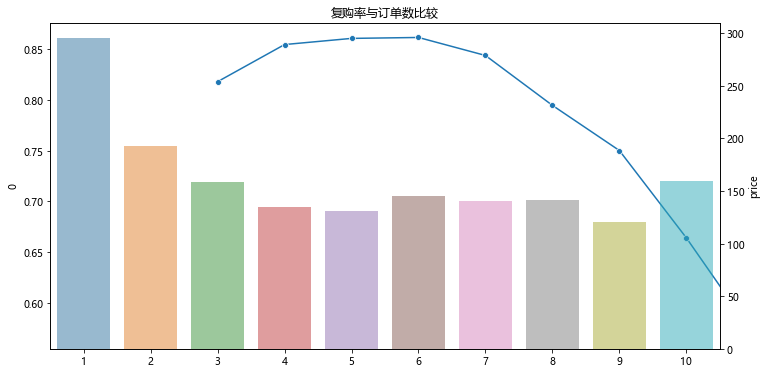

In [68]:
fig, ax1 = plt.subplots(figsize=(12,6))

sb.lineplot(data = order_fq[0], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sb.barplot(data = order_total, x='month', y='price', alpha=0.5, ax=ax2)
plt.title('复购率与订单数比较')

根据数据显示，此电商的复购率一直保持较高的位置（80%的高位）随后逐步下降（从订购8次以后）。鉴于行业平均值仅为40%，从此看出会员的忠诚度一直维持的比较好。

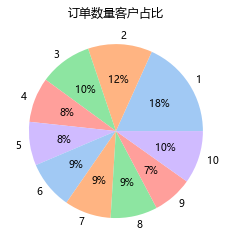

In [81]:
plt.pie(ord, labels = ord.index,colors=colors, autopct='%.0f%%')
plt.title('订单数量客户占比')
plt.show()

### 4.3 用户购买周期

In [122]:
con = (df_b.groupby(['user_id'])['order_id'].count()).to_frame()
con['user_id']=con.index 
con = con[con['order_id']>1]

In [209]:
df_c = df.loc[df['user_id'].isin(user_record[user_record>1].index)]
df_c = df_c.loc[df_c['event_time']!='1970-01-01']

In [210]:
df_c['rank'] = df_c.groupby(['user_id'])['event_time'].rank(ascending=True)

In [211]:
con2 = df_c.loc[df_c['rank']==1]
con2 = df_c.loc[df_c['rank']==2]
con = pd.merge(left=con1,right =  con2,how = 'inner', on = 'user_id')

In [212]:
con['date_diff'] = (con['event_time_y']-con['event_time_x']) / np.timedelta64(1, 'D')
cond=con.groupby(['date_diff'])['user_id'].count().to_frame()
cond['date_diff']=cond.index
cond = cond.iloc[1:]

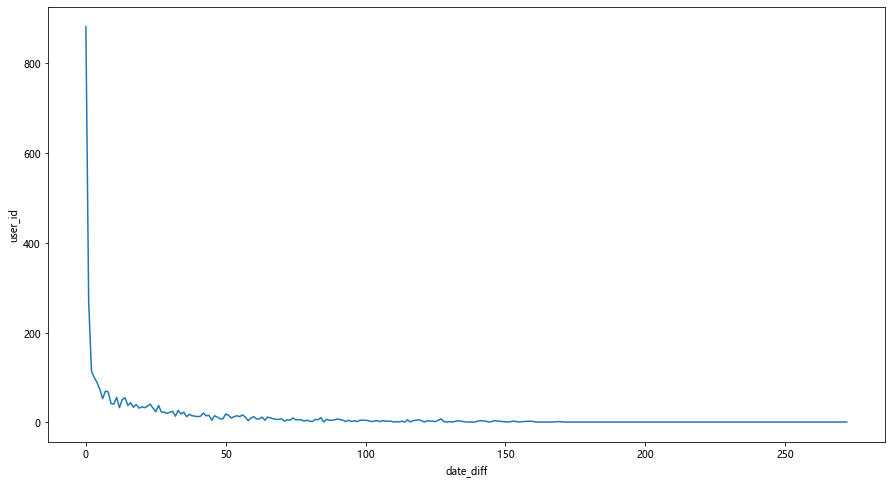

In [213]:
plt.figure(figsize = (15,8))
sb.lineplot( x = "date_diff",
             y = "user_id",
             data = cond)

从数据中发现，用户的二次购买一般都发生在几天的时间内，然而也有很大一部分发生在较长的时间（100天）以外。
建议定期对刚下单的用户做跟踪运营，确保用户在较短时间内做二次下单，避免用户变休眠。

## 5. 用户RFM分类

In [221]:
freq = (df.groupby(['user_id'])['order_id'].count()).to_frame().reset_index()
money = (df.groupby(['user_id'])['price'].sum()).to_frame().reset_index()

In [227]:
freq['order_id'].median()

22.0

In [228]:
money['price'].median()

5459.7

In [250]:
con = pd.merge(left=freq,right =  money,how = 'inner', on = 'user_id')

In [251]:
def rfm(row):
    if row['order_id']>22 and row['price']>5459.7:
        return '重要客户'
    elif row['order_id']>22 and row['price']<5459.7:
        return '高频客户'
    elif row['order_id']<22 and row['price']<5459.7:
        return '观察用户'
    else:
        return '高潜力客户'
    
con['type']=con.apply (lambda row: rfm(row), axis=1)
con = con.groupby(['type']).count()
con = con.drop(['order_id','price'],axis=1)
con = con.squeeze()

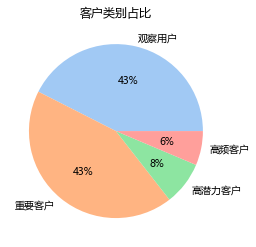

In [258]:
plt.pie(con, labels = con.index,colors=colors, autopct='%.0f%%')
plt.title('客户类别占比')
plt.show()

运营部门可针对不同客户进行的营销方案。
要注意的是有很大一部分客户（观察用户）有订单数量低，消费金额低的现象，建议对其展开有针对性的营销活动以增加活跃度。

# 结论：

1.数据显示，会员管理体系较为出色，复购率高且高价值客户占销售额占比也较高。

2.新注册用户一直维持在较低的水平，可对此加大营销力度。

3.夏天期间销售额出现了量价起升的现象，且很多休眠用户也选择了回归。可复盘此段时间的营销数据总结经验。

4.电子产品依旧占据了主营业务，且对前十大品牌有较大的依赖度。

5.尽管复购率较高，但很多用户二次订单的时间与首次下单间隔依旧较长。建议对新下单客户加大后续跟踪营销的服务。

Tableau 初始数据dashboard：
https://public.tableau.com/app/profile/tian.xu/viz/1_16593274745330/1?publish=yes